## RandAugmentation_vanila
- baseline code가 존재하는 디렉토리에 해당 노트북을 다운받아 실행해주시기바랍니다.

In [ ]:
import torch
import os
import sys
import yaml
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from typing import Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

if "./" not in sys.path:
    sys.path.append("./")

In [ ]:
from src.model import Model
from src.trainer import TorchTrainer
from src.loss import CustomCriterion

In [ ]:
MEAN_V = (0.4914, 0.4822, 0.4465)
STD_V = (0.2470, 0.2435, 0.2616)

DATASET_DIR = "./input/cifar10"

In [ ]:
def generate_transform(resize: int = 32, aug_fcns: Tuple = ()) -> transforms.transforms.Compose:
    """Generate train augmentation policy."""
    transform_fcns = []
    transform_fcns.append(transforms.Resize((resize, resize)))
    transform_fcns += list(aug_fcns)
    
    transform_fcns.append(transforms.ToTensor())
    transform_fcns.append(transforms.Normalize(MEAN_V, STD_V))
    
    return transforms.Compose(transform_fcns)
    

In [ ]:
def load_cifar10(img_size: int = 32, 
                 aug_fcns: Tuple = (), 
                 validation_ratio: float = 0.8,
                ) -> Tuple[CIFAR10, CIFAR10, CIFAR10]:
    tf_train = generate_transform(resize=img_size, aug_fcns=aug_fcns)
    tf_test = generate_transform(resize=img_size)
    
    train_dataset = CIFAR10(root=DATASET_DIR, train=True, download=True, transform=tf_train)
    train_length = int(len(train_dataset) * validation_ratio)
    val_length = len(train_dataset) - train_length

    train_dataset, val_dataset = random_split(train_dataset, [train_length, val_length])
    test_dataset = CIFAR10(root=DATASET_DIR, train=False, download=True, transform=tf_test)
    
    return train_dataset, val_dataset, test_dataset
    

In [ ]:
img_size = 32

augmentation_functions = (
    transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5)), 
    transforms.RandomPerspective(),
    transforms.RandomHorizontalFlip(),
)

train_dataset, val_dataset, test_dataset = load_cifar10(img_size=img_size, aug_fcns = augmentation_functions, validation_ratio=0.8)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def tensor_to_img(tensor_img: torch.Tensor) -> np.ndarray:
    return ((tensor_img.permute(1, 2, 0).numpy() * STD_V + MEAN_V) * 255).astype(np.uint8)

def visualize_datasets(_train_dataset: CIFAR10, _val_dataset: CIFAR10, _test_dataset: CIFAR10, title_prefix: str = "") -> None:
    fig, ax = plt.subplots(3, 7, figsize=(20, 10))

    for i in range(7):
        idx = np.random.randint(0, len(val_dataset))

        ax[0][i].imshow(tensor_to_img(_train_dataset[idx][0]))
        ax[1][i].imshow(tensor_to_img(_val_dataset[idx][0]))
        ax[2][i].imshow(tensor_to_img(_test_dataset[idx][0]))

        ax[0][i].axis('off')
        ax[1][i].axis('off')
        ax[2][i].axis('off')

    fig.suptitle(f"{title_prefix} Visualization of Augmentation.\n(Each row represents train, validation, test dataset accordingly)")
    fig.show()

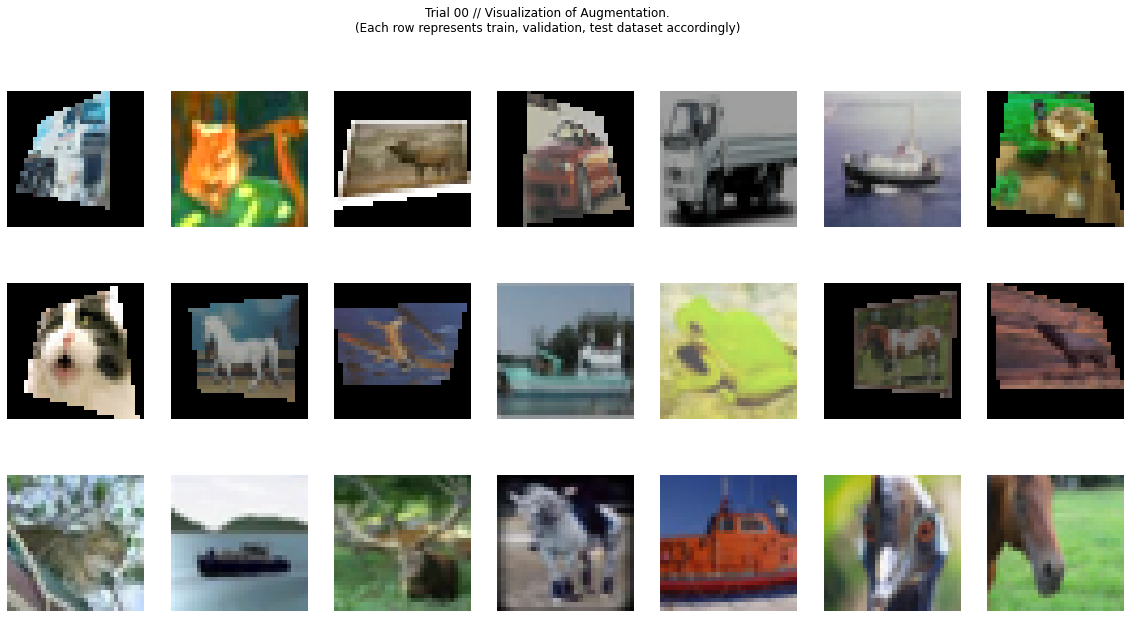

In [ ]:
visualize_datasets(train_dataset, val_dataset, test_dataset, title_prefix="Trial 00 //")

In [ ]:
import yaml

In [ ]:
with open("./configs/model/mobilenetv3.yaml", "r") as f:
    model_cfg = yaml.load(f, yaml.SafeLoader)

model_cfg['backbone'][-1][-1] = [10]

model = Model(model_cfg, verbose=True)

idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResidual

In [ ]:
EPOCHS = 10
BATCH_SIZE = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

optimizer = torch.optim.SGD(model.model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.1, steps_per_epoch=len(train_dataset), epochs=EPOCHS, pct_start=0.05)
criterion = CustomCriterion(samples_per_cls=None, device=device)

train_loader = DataLoader(dataset=train_dataset, 
                          pin_memory=torch.cuda.is_available(), 
                          shuffle=True, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, 
                          drop_last=True)
val_loader = DataLoader(dataset=val_dataset, 
                        pin_memory=torch.cuda.is_available(), 
                        shuffle=False, 
                        batch_size=BATCH_SIZE, 
                        num_workers=4)
test_loader = DataLoader(dataset=test_dataset, 
                         pin_memory=torch.cuda.is_available(), 
                         shuffle=False, 
                         batch_size=BATCH_SIZE, 
                         num_workers=4)
    
exp_dir = "./exp/autoaug"
os.makedirs(exp_dir, exist_ok=True)
trainer = TorchTrainer(model=model, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       scheduler=scheduler, 
                       device=device, 
                       verbose=1, 
                       model_path=os.path.join(exp_dir, "best.pt"))

best_acc, best_f1 = trainer.train(train_dataloader=train_loader, 
                                  n_epoch=EPOCHS, 
                                  val_dataloader=val_loader)

Train: [001] Loss: 2.187, Acc: 17.97% F1(macro): 0.18: 100%|██████████| 156/156 [00:15<00:00, 10.38it/s]
 Val:       Loss: 1.972, Acc: 26.79% F1(macro): 0.25: 100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


Model saved. Current best test f1: 0.247


Train: [002] Loss: 1.834, Acc: 31.65% F1(macro): 0.31: 100%|██████████| 156/156 [00:14<00:00, 10.42it/s]
 Val:       Loss: 1.745, Acc: 35.67% F1(macro): 0.35: 100%|██████████| 40/40 [00:02<00:00, 13.91it/s]


Model saved. Current best test f1: 0.352


Train: [003] Loss: 1.684, Acc: 38.13% F1(macro): 0.38: 100%|██████████| 156/156 [00:14<00:00, 10.70it/s]
 Val:       Loss: 1.667, Acc: 39.00% F1(macro): 0.38: 100%|██████████| 40/40 [00:02<00:00, 14.15it/s]


Model saved. Current best test f1: 0.379


Train: [004] Loss: 1.606, Acc: 41.14% F1(macro): 0.41: 100%|██████████| 156/156 [00:14<00:00, 10.54it/s]
 Val:       Loss: 1.620, Acc: 40.87% F1(macro): 0.40: 100%|██████████| 40/40 [00:02<00:00, 14.29it/s]


Model saved. Current best test f1: 0.400


Train: [005] Loss: 1.555, Acc: 42.90% F1(macro): 0.42: 100%|██████████| 156/156 [00:14<00:00, 10.64it/s]
 Val:       Loss: 1.572, Acc: 43.76% F1(macro): 0.42: 100%|██████████| 40/40 [00:02<00:00, 13.65it/s]


Model saved. Current best test f1: 0.425


Train: [006] Loss: 1.506, Acc: 45.42% F1(macro): 0.45: 100%|██████████| 156/156 [00:14<00:00, 10.71it/s]
 Val:       Loss: 1.490, Acc: 45.77% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 14.04it/s]


Model saved. Current best test f1: 0.457


Train: [007] Loss: 1.463, Acc: 46.87% F1(macro): 0.47: 100%|██████████| 156/156 [00:14<00:00, 10.78it/s]
 Val:       Loss: 1.451, Acc: 47.89% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 13.95it/s]


Model saved. Current best test f1: 0.474


Train: [008] Loss: 1.434, Acc: 48.29% F1(macro): 0.48: 100%|██████████| 156/156 [00:14<00:00, 10.79it/s]
 Val:       Loss: 1.453, Acc: 46.70% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]
Train: [009] Loss: 1.398, Acc: 49.63% F1(macro): 0.49: 100%|██████████| 156/156 [00:14<00:00, 10.51it/s]
 Val:       Loss: 1.398, Acc: 48.98% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 14.10it/s]


Model saved. Current best test f1: 0.486


Train: [010] Loss: 1.373, Acc: 50.76% F1(macro): 0.50: 100%|██████████| 156/156 [00:14<00:00, 10.80it/s]
 Val:       Loss: 1.402, Acc: 49.78% F1(macro): 0.50: 100%|██████████| 40/40 [00:02<00:00, 13.96it/s]


Model saved. Current best test f1: 0.497


In [ ]:
test_loss, test_f1, test_accuracy = trainer.test(model, test_loader)

 Val:       Loss: 1.207, Acc: 55.60% F1(macro): 0.55: 100%|██████████| 40/40 [00:01<00:00, 24.64it/s]
